In [2]:
from PIL import Image
import cv2
import numpy
from time import time

from preprocess.humanparsing.run_parsing import Parsing
from preprocess.openpose.run_openpose import OpenPose
import matplotlib.pyplot as plt
from masking import get_mask_location


In [3]:
parsing_model = Parsing(-1)
openpose_model = OpenPose(-1)

In [4]:
# human_img = Image.open("/Users/zohaib.munir/Downloads/2024-07-18_05-44-21_7351.png").convert('RGB').resize((768,1024))
human_img = Image.open("hasnain.jpg").convert('RGB')
target_size = human_img.size
human_img = human_img.resize(((768,1024)))
target_size

(1080, 1920)

In [100]:
keypoints = openpose_model(human_img.resize((384,512)))
# keypoints = openpose_model(human_img)

In [101]:
model_parse, _ = parsing_model(human_img.resize((384,512)))
# model_parse, _ = parsing_model(human_img)

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


In [102]:
mask, mask_gray = get_mask_location('hd', "upper_body", model_parse, keypoints)

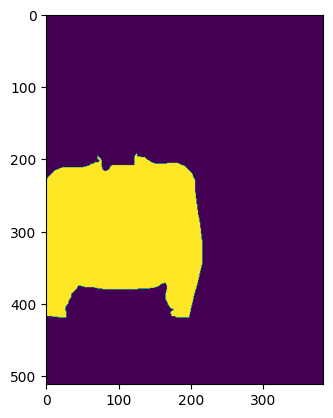

In [103]:
mask_gray = mask_gray.resize((768,1024))
# Show using matplotlib
plt.imshow(mask)
plt.show()

In [104]:
numpy.asarray(mask).shape

(512, 384)

In [105]:
mask.show()

In [108]:
mask.resize(target_size).show()

In [4]:
import numpy as np
import cv2
from PIL import Image
from preprocess.humanparsing.run_parsing import Parsing
from preprocess.openpose.run_openpose import OpenPose

class Masking:
    def __init__(self):
        self.parsing_model = Parsing(-1)
        self.openpose_model = OpenPose(-1)
        self.label_map = {
            "background": 0, "hat": 1, "hair": 2, "sunglasses": 3, "upper_clothes": 4,
            "skirt": 5, "pants": 6, "dress": 7, "belt": 8, "left_shoe": 9, "right_shoe": 10,
            "head": 11, "left_leg": 12, "right_leg": 13, "left_arm": 14, "right_arm": 15,
            "bag": 16, "scarf": 17, "neck": 18
        }

    def get_mask(self, img, category='upper_body'):
        # Resize image to 384x512 for processing
        img_resized = img.resize((384, 512), Image.Resampling.LANCZOS)
        
        # Get human parsing result
        parse_result, _ = self.parsing_model(img_resized)
        parse_array = np.array(parse_result)

        # Get pose estimation
        keypoints = self.openpose_model(img_resized)
        pose_data = np.array(keypoints["pose_keypoints_2d"]).reshape((-1, 2))

        # Create initial mask based on category
        if category == 'upper_body':
            mask = np.isin(parse_array, [self.label_map["upper_clothes"], self.label_map["dress"]])
        elif category == 'lower_body':
            mask = np.isin(parse_array, [self.label_map["pants"], self.label_map["skirt"]])
        elif category == 'dresses':
            mask = np.isin(parse_array, [self.label_map["upper_clothes"], self.label_map["dress"], 
                                         self.label_map["pants"], self.label_map["skirt"]])
        else:
            raise ValueError("Invalid category. Choose 'upper_body', 'lower_body', or 'dresses'.")

        # Create arm mask
        arm_mask = np.isin(parse_array, [self.label_map["left_arm"], self.label_map["right_arm"]])

        # Create hand mask using pose data
        hand_mask = self.create_hand_mask(pose_data, parse_array.shape)

        # Combine arm and hand mask
        arm_hand_mask = np.logical_or(arm_mask, hand_mask)

        # Remove arms and hands from the mask
        mask = np.logical_and(mask, np.logical_not(arm_hand_mask))

        # Refine the mask
        mask = self.refine_mask(mask)

        # Resize mask back to original image size
        mask_pil = Image.fromarray(mask.astype(np.uint8) * 255)
        mask_pil = mask_pil.resize(img.size, Image.Resampling.LANCZOS)
        
        return np.array(mask_pil)

    def create_hand_mask(self, pose_data, shape):
        hand_mask = np.zeros(shape, dtype=np.uint8)
        
        # Right hand
        if pose_data[4][0] > 0 and pose_data[4][1] > 0:  # If right wrist is detected
            cv2.circle(hand_mask, (int(pose_data[4][0]), int(pose_data[4][1])), 30, 255, -1)
        
        # Left hand
        if pose_data[7][0] > 0 and pose_data[7][1] > 0:  # If left wrist is detected
            cv2.circle(hand_mask, (int(pose_data[7][0]), int(pose_data[7][1])), 30, 255, -1)
        
        return hand_mask > 0  # Convert back to boolean mask

    def refine_mask(self, mask):
        # Convert to uint8 for OpenCV operations
        mask_uint8 = mask.astype(np.uint8) * 255
        
        # Apply morphological operations to smooth the mask
        kernel = np.ones((5,5), np.uint8)
        mask_uint8 = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
        mask_uint8 = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel)
        
        # Find contours and keep only the largest one
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            mask_refined = np.zeros_like(mask_uint8)
            cv2.drawContours(mask_refined, [largest_contour], 0, 255, -1)
        else:
            mask_refined = mask_uint8
        
        return mask_refined > 0  # Convert back to boolean mask

if __name__ == "__main__":
    masker = Masking()
    human_img = Image.open("images/ok.png").convert('RGB')
    mask = masker.get_mask(human_img, category='upper_body')
    Image.fromarray(mask).show()

ModuleNotFoundError: No module named 'onnxruntime'

In [2]:
pip install numpy opencv-python Pillow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 307.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 8.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 23.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
